In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

In [6]:
bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')


In [7]:
bikes.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
bikes.describe

<bound method NDFrame.describe of                   datetime  season  holiday  workingday  weather   temp  \
0      2011-01-01 00:00:00       1        0           0        1   9.84   
1      2011-01-01 01:00:00       1        0           0        1   9.02   
2      2011-01-01 02:00:00       1        0           0        1   9.02   
3      2011-01-01 03:00:00       1        0           0        1   9.84   
4      2011-01-01 04:00:00       1        0           0        1   9.84   
...                    ...     ...      ...         ...      ...    ...   
10881  2012-12-19 19:00:00       4        0           1        1  15.58   
10882  2012-12-19 20:00:00       4        0           1        1  14.76   
10883  2012-12-19 21:00:00       4        0           1        1  13.94   
10884  2012-12-19 22:00:00       4        0           1        1  13.94   
10885  2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  
0

<Axes: xlabel='count', ylabel='Count'>

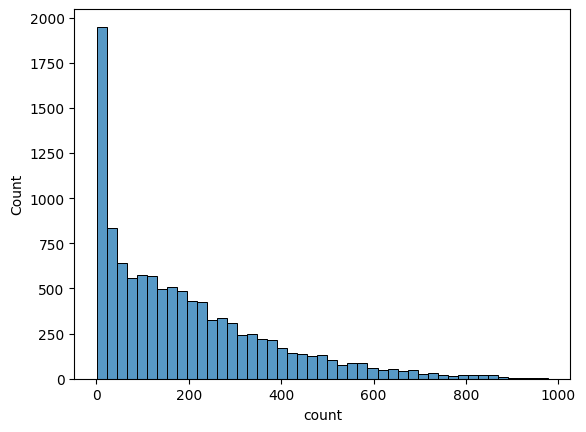

In [9]:
sns.histplot(bikes['count'])

In [10]:
#recreate our time of day values
# recreate our time of day values
bikes['datetime'] = pd.to_datetime(bikes['datetime'])

In [11]:
bikes['hour'] = bikes['datetime'].apply(lambda x: x.hour)

In [12]:
# filter for rush hour rentals in the evenings and use that as a proxy for "high number of rentals"
# But why evening number serve as proxy?
bikes[(bikes['hour'] >= 15) & (bikes['hour']<=19)]['count'].mean()

357.11491228070173

In [13]:
bikes['binary_output'] = bikes['count'].apply(lambda x: 1 if x>=357 else 0)

In [14]:
bikes.groupby('binary_output')['datetime'].count()

binary_output
0    9026
1    1860
Name: datetime, dtype: int64

<Axes: xlabel='hour', ylabel='count'>

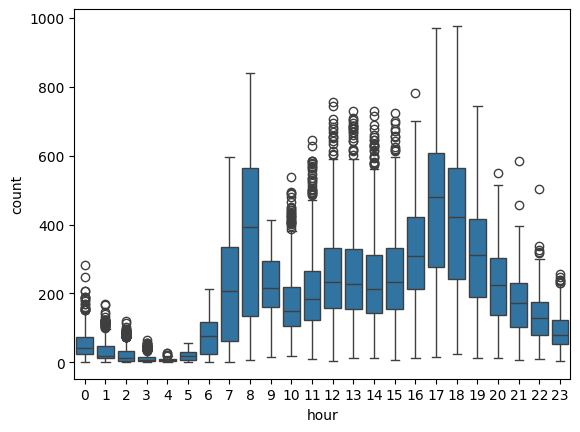

In [15]:
sns.boxplot(x='hour', y='count', data=bikes)

In [16]:
bikes.columns


Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'binary_output'],
      dtype='object')

In [17]:
#'casual', 'registered', 'count','hour', 'binary_output' cannot use
# split data into X variables and y variable
# we are going to predict whether on any given hour, we will rent a HIGH number of bikes (1 = 357+ bikes) OR a LOW number of bikes (0 = <357 bikes)
X = bikes[['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour']]
y = bikes['binary_output']

In [18]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [19]:
# scale between 0 to 1 for variables
MinMaxScaler().fit_transform(bikes[['temp','atemp', 'humidity', 'windspeed']])

array([[0.2244898 , 0.30506768, 0.81      , 0.        ],
       [0.20408163, 0.28806354, 0.8       , 0.        ],
       [0.20408163, 0.28806354, 0.8       , 0.        ],
       ...,
       [0.32653061, 0.33896409, 0.61      , 0.26319502],
       [0.32653061, 0.3728605 , 0.61      , 0.10532503],
       [0.30612245, 0.35585636, 0.66      , 0.15786999]])

In [20]:
bikes[['temp',
       'atemp','humidity','windspeed']]

,temp,atemp,humidity,windspeed
0,9.84,14.395,81,0.0000
1,9.02,13.635,80,0.0000
2,9.02,13.635,80,0.0000
3,9.84,14.395,75,0.0000
4,9.84,14.395,75,0.0000
...,...,...,...,...
10881,15.58,19.695,50,26.0027
10882,14.76,17.425,57,15.0013
10883,13.94,15.910,61,15.0013
10884,13.94,17.425,61,6.0032


In [21]:
bikes[['season', 'holiday', 'workingday']]

,season,holiday,workingday
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
10881,4,0,1
10882,4,0,1
10883,4,0,1
10884,4,0,1


In [22]:
#demonstrate ONE
OneHotEncoder().fit_transform(bikes[['season', 'holiday', 'workingday']])

<10886x8 sparse matrix of type '<class 'numpy.float64'>'
	with 32658 stored elements in Compressed Sparse Row format>

In [23]:
bikes[['season', 'holiday', 'workingday']]

,season,holiday,workingday
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
10881,4,0,1
10882,4,0,1
10883,4,0,1
10884,4,0,1


In [24]:
# build our pipeline that includes these transformations
numeric_columns = ['temp','atemp', 'humidity', 'windspeed']
categorical_columns = ['season', 'holiday', 'workingday', 'weather']

In [25]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals 
# numeric --> minmax
# categorical --> onehot-encoding
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [26]:
# we are going to test 3 models with cross validation to see which ones work best for this data
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()

In [27]:
# cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [28]:
print(np.mean(knn_scores))
print(np.mean(logreg_scores))
print(np.mean(nb_scores))

0.44890861216373584
0.217337123821701
0.4759934888351841


In [29]:
# a quick side-quest demo of how KNN works
knn_15 = KNeighborsClassifier(n_neighbors=15).fit(X_train,y_train)
pred_15 = knn_15.predict(X_test)
print(accuracy_score(y_test, pred_15))
print(f1_score(y_test, pred_15))
print(precision_score(y_test, pred_15))
print(recall_score(y_test, pred_15))

0.8573178199632578
0.45433255269320844
0.6576271186440678
0.3470483005366726


In [30]:
# a quick side-quest demo of how KNN works
knn_30 = KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train)
pred_30 = knn_30.predict(X_test)
print(accuracy_score(y_test, pred_30))
print(f1_score(y_test, pred_30))
print(precision_score(y_test, pred_30))
print(recall_score(y_test, pred_30))

0.8551745254133497
0.4005069708491762
0.6869565217391305
0.2826475849731664


In [31]:
# DON't have to test all k

In [32]:
# build our pipeline
pipeline = Pipeline(steps=
                    [
                        ('preprocessor',preprocessor),
                        ('classifier',KNeighborsClassifier())
                    ])

In [33]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid = {
    'classifier__n_neighbors':[5,7,9,15,35,45,55],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','manhattan','minkowski']
}


In [34]:

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__max_iter': [100, 200, 300]
}

In [35]:
# 5 cross validation
# let's perform gridsearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['season',
                                                                          'holiday',
                                                                          'workingday',
                                                                          'weather'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [36]:
print(grid_search.best_params_)

{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}


In [37]:
final_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors'],
                                        metric = grid_search.best_params_['classifier__metric'],
                                        weights = grid_search.best_params_['classifier__weights']
                                        )

In [38]:
final_pipeline = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor),
                              ('classifier',final_classifier)
                          ])

In [39]:
final_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season', 'holiday',
                                                   'workingday',
                                                   'weather'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=7,
                                      weights='distance'))])

In [40]:
pred = final_pipeline.predict(X_test)

In [41]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
probs = final_pipeline.predict_proba(X_test)

In [43]:
probs

array([[0.83977132, 0.16022868],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.84116015, 0.15883985],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [44]:
f1_score(y_test, pred)


0.4157303370786517

In [45]:
accuracy_score(y_test,pred)


0.840783833435395

In [46]:
precision_score(y_test,pred)


0.5589123867069486

In [47]:
recall_score(y_test,pred)

0.33094812164579607

In [48]:
probs

array([[0.83977132, 0.16022868],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.84116015, 0.15883985],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [49]:
import seaborn as sns
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix


Text(0.5, 23.52222222222222, 'Predicted Classes')

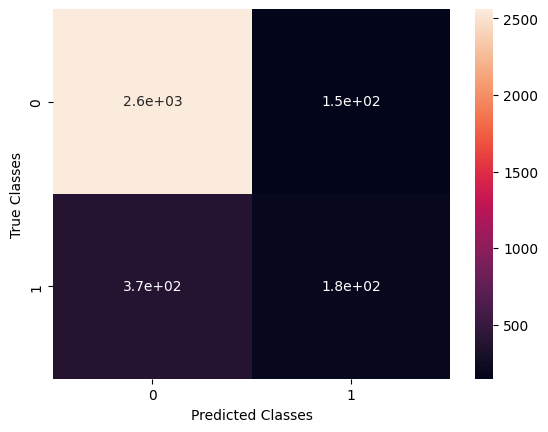

In [51]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

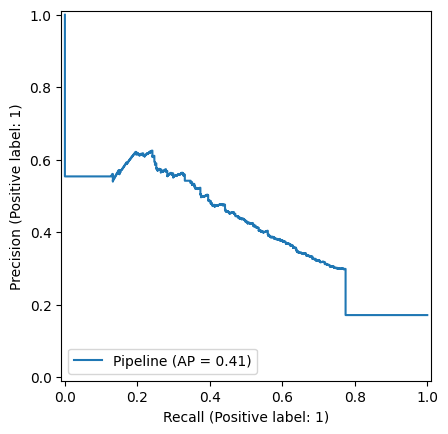

In [53]:
# Precision Recall Curve
display = PrecisionRecallDisplay.from_estimator(final_pipeline, X_test, y_test)

In [54]:
# adjust to 70% threshold
new_predictions =[]
for i in probs[:,1]:
    if i >= 0.7:
        new_predictions.append(1)
    else:
        new_predictions.append(0)

Text(0.5, 23.52222222222222, 'New Predicted Classes')

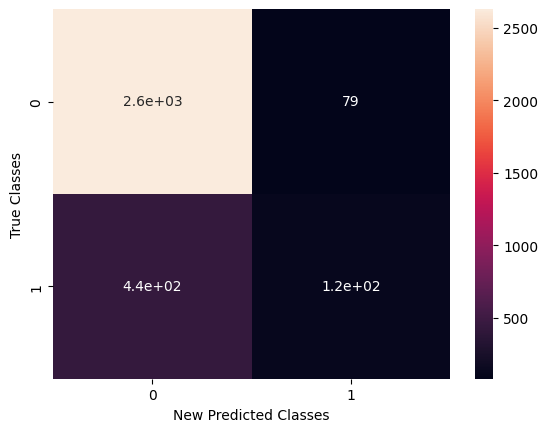

In [55]:
sns.heatmap(confusion_matrix(y_test, new_predictions), annot=True)
plt.ylabel('True Classes')
plt.xlabel('New Predicted Classes')

In [58]:
# tradeoff between True Positive & False Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])

In [60]:
thresholds

array([           inf, 1.00000000e+00, 9.99997289e-01, 9.99996845e-01,
       9.99994075e-01, 8.88340407e-01, 8.87422358e-01, 8.86125822e-01,
       8.78454727e-01, 8.78310592e-01, 8.63522516e-01, 8.61592211e-01,
       7.68805017e-01, 7.68406303e-01, 7.55853481e-01, 7.50000000e-01,
       7.48533031e-01, 7.47071158e-01, 7.45121321e-01, 7.44876621e-01,
       7.37396571e-01, 7.37064897e-01, 7.26453438e-01, 7.21232213e-01,
       7.16917078e-01, 7.14831562e-01, 7.10481238e-01, 7.03742829e-01,
       7.01818206e-01, 7.00544893e-01, 6.82865953e-01, 6.75753640e-01,
       6.71832828e-01, 6.71352706e-01, 6.65953100e-01, 6.43566555e-01,
       6.42509505e-01, 6.38352299e-01, 6.36122901e-01, 6.25373420e-01,
       6.24805349e-01, 6.15327763e-01, 6.11968347e-01, 6.04964601e-01,
       6.04872763e-01, 6.04144086e-01, 6.03818093e-01, 6.00613911e-01,
       5.97240974e-01, 5.94017212e-01, 5.93306176e-01, 5.92904369e-01,
       5.92779780e-01, 5.88248182e-01, 5.86067073e-01, 5.86023756e-01,
      

Text(0, 0.5, 'True Positive Rate')

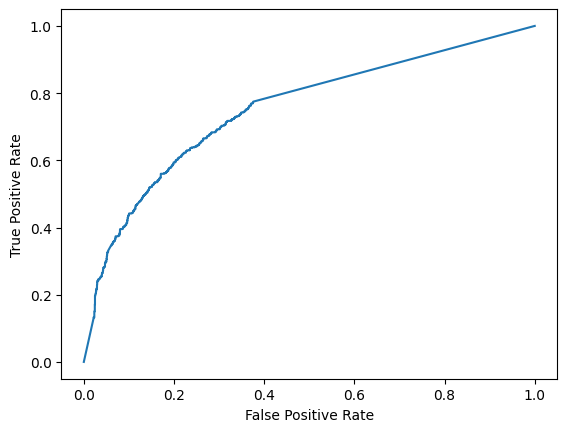

In [57]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
# can draw ROC in this case
